# Curation of Core Mammalian Cardiac Proteome
In this notebook, we are merging the individual protein lists curated from proteomics experiments in four mammalian species. We remove duplicates, map these protein lists to genes, remove redundant proteins based on their sequence similarity, and generate figures to visualize these results.

## Merge experimental datasets

In [1]:
! ls ../data/
! ls ../data/uniprot_reference_proteomes/
! ls ../data/protein_lists/

protein_lists  uniprot_reference_proteomes
homo_sapiens_uniprot-proteome_UP000005640_2022-04-26.fasta
mus_musculus_uniprot-proteome_UP000000589_2022-04-26.fasta
rattus_norvegicus_uniprot-proteome_UP000002494_2022-04-26.fasta
sus_scrofa_uniprot-proteome_UP000008227_2022-04-26.fasta
human_protein_lists  mouse_protein_lists  pig_protein_lists  rat_protein_lists


In [2]:
# reference proteomes
human_uniprot_ref = "../data/uniprot_reference_proteomes/homo_sapiens_uniprot-proteome_UP000005640_2022-04-26.fasta"
mouse_uniprot_ref = "../data/uniprot_reference_proteomes/mus_musculus_uniprot-proteome_UP000000589_2022-04-26.fasta"
rat_uniprot_ref = "../data/uniprot_reference_proteomes/rattus_norvegicus_uniprot-proteome_UP000002494_2022-04-26.fasta"
pig_uniprot_ref = "../data/uniprot_reference_proteomes/sus_scrofa_uniprot-proteome_UP000008227_2022-04-26.fasta"

# input protein lists
human_protein_lists = "../data/protein_lists/human_protein_lists"
mouse_protein_lists = "../data/protein_lists/mouse_protein_lists"
rat_protein_lists = "../data/protein_lists/rat_protein_lists"
pig_protein_lists = "../data/protein_lists/pig_protein_lists"

In [3]:
import os

def get_proteins_from_fasta(file_name):
    proteins = set()
    reviewed = set()
    unreviewed = set()
    for l in [l.strip("\n") for l in open(file_name,"r").readlines()]:
        if ">" in l:
            accession = l.split("|")[1]
            proteins.add(accession)
            if "tr" in l:
                unreviewed.add(accession)
            elif "sp" in l:
                reviewed.add(accession)
    print("%d proteins (%d reviwed, %d unreviewed) in %s" %(len(proteins),len(reviewed),len(unreviewed),file_name))
    return proteins,reviewed,unreviewed


def merge_lists(input_directory = "./protein_lists", 
                out_file = "./merged_list.txt",
                remove_isoforms = False,
                filter_with_uniprot_db_file = None):
    '''
    This function reads all the .txt files in the input directory and merges the unique identifiers into merged_list.txt
    '''
    input_files = []
    # get all file names
    for filename in os.listdir(input_directory):
        if filename.endswith(".txt"):
            #print(os.path.join(input_directory, filename))
            input_files += [os.path.join(input_directory, filename)]
        else:
            continue
    print("%d files in directory %s" %(len(input_files),input_directory))

    # load uniprot database if filter_with_uniprot_db_file is specified
    if filter_with_uniprot_db_file != None:
        uniprot_all, uniprot_reviewed, uniprot_unreviewed = get_proteins_from_fasta(filter_with_uniprot_db_file)

    # read all files and extract proteins for each
    id_to_proteins = {}
    total_prot_count = 0
    for f in input_files:
        id = f.split("/")[-1].strip(".txt")
        #print(id)
        proteins = set(filter(None, [l.strip("\n") for l in open(f,"r").readlines()]))
        id_to_proteins[id] = proteins
        total_prot_count += len(proteins)
    print("Total number of proteins among all files: %s"%total_prot_count)

    # get unique protein list
    unique_proteins = set()
    for id in id_to_proteins.keys():
        proteins = id_to_proteins[id]
        unique_proteins = unique_proteins.union(proteins)
    print("%d unique proteins identified" %(len(unique_proteins)))

    # remove isoforms
    if remove_isoforms:
        prots = list(unique_proteins)
        unique_proteins = set()
        num_isoforms = 0
        for p in prots:
            if "-" not in p:
                unique_proteins.add(p)
            else:
                unique_proteins.add(p.split("-")[0])
                num_isoforms += 1
        print("Number of isoforms replaced: %d" %num_isoforms)
        print("%d unique proteins identified after removing isoforms" %(len(unique_proteins)))

        
    # cross reference against uniprot database
    if (filter_with_uniprot_db_file != None):
        prots = list(unique_proteins)
        unique_proteins = set()

        # only keep proteins in the uniprot db
        for p in prots:
            if p in uniprot_all:
                unique_proteins.add(p)

        # separated by experiment, only keep proteins in uniprot db
        filtered_id_to_proteins = {}
        for id in id_to_proteins.keys():
            proteins = id_to_proteins[id]
            filtered_proteins = proteins.intersection(unique_proteins)
            if len(filtered_proteins) > 0:
                filtered_id_to_proteins[id] = filtered_proteins
        print("After filtering, %d experiments have relevant proteins" %(len(filtered_id_to_proteins)))
        print("Total number of proteins among all files, filtering with Uniprot: %s"%len(unique_proteins))

    # write file
    with open(out_file,"w") as out_f:
        out_f.write("\n".join(list(unique_proteins)))
        print("Written to file %s"%out_file)
    return unique_proteins, filtered_id_to_proteins


In [4]:
pig_proteins_uniprot, pig_reviewed, pig_unreviewed = get_proteins_from_fasta(pig_uniprot_ref)
unique_pig_proteins, pig_id_to_proteins = merge_lists(remove_isoforms=True, 
                                                      out_file="merged_pig_list.txt",
                                                      input_directory = pig_protein_lists,
                                                      filter_with_uniprot_db_file = pig_uniprot_ref)
pig_uniprot_proteome_overlap = unique_pig_proteins.intersection(pig_proteins_uniprot)
pig_reviewed_overlap = unique_pig_proteins.intersection(pig_reviewed)
pig_unreviewed_overlap = unique_pig_proteins.intersection(pig_unreviewed)
print("%d our of %d proteins overlap with the list of %d proteins from the Sus scrofa uniprot database" 
      %(len(pig_uniprot_proteome_overlap),len(unique_pig_proteins),len(pig_proteins_uniprot)))
print("%d reviewed, %d unreviewed" %(len(pig_reviewed_overlap),len(pig_unreviewed_overlap)))

49793 proteins (1242 reviwed, 48551 unreviewed) in ../data/uniprot_reference_proteomes/sus_scrofa_uniprot-proteome_UP000008227_2022-04-26.fasta
11 files in directory ../data/protein_lists/pig_protein_lists
49793 proteins (1242 reviwed, 48551 unreviewed) in ../data/uniprot_reference_proteomes/sus_scrofa_uniprot-proteome_UP000008227_2022-04-26.fasta
Total number of proteins among all files: 14394
11373 unique proteins identified
Number of isoforms replaced: 54
11372 unique proteins identified after removing isoforms
After filtering, 11 experiments have relevant proteins
Total number of proteins among all files, filtering with Uniprot: 7571
Written to file merged_pig_list.txt
7571 our of 7571 proteins overlap with the list of 49793 proteins from the Sus scrofa uniprot database
465 reviewed, 7106 unreviewed


In [5]:
human_proteins_uniprot, human_reviewed, _ = get_proteins_from_fasta(human_uniprot_ref)
unique_human_proteins, human_id_to_proteins = merge_lists(remove_isoforms=True, 
                                                      out_file="merged_human_list.txt",
                                                      input_directory = human_protein_lists,
                                                      filter_with_uniprot_db_file = human_uniprot_ref)

79052 proteins (17837 reviwed, 61215 unreviewed) in ../data/uniprot_reference_proteomes/homo_sapiens_uniprot-proteome_UP000005640_2022-04-26.fasta
10 files in directory ../data/protein_lists/human_protein_lists
79052 proteins (17837 reviwed, 61215 unreviewed) in ../data/uniprot_reference_proteomes/homo_sapiens_uniprot-proteome_UP000005640_2022-04-26.fasta
Total number of proteins among all files: 51797
31686 unique proteins identified
Number of isoforms replaced: 2776
28924 unique proteins identified after removing isoforms
After filtering, 9 experiments have relevant proteins
Total number of proteins among all files, filtering with Uniprot: 16883
Written to file merged_human_list.txt


In [6]:
mouse_proteins_uniprot, mouse_reviewed, _ = get_proteins_from_fasta(mouse_uniprot_ref)
unique_mouse_proteins, mouse_id_to_proteins = merge_lists(remove_isoforms=True, 
                                                      out_file="merged_mouse_list.txt",
                                                      input_directory = mouse_protein_lists,
                                                      filter_with_uniprot_db_file = mouse_uniprot_ref)

55315 proteins (14755 reviwed, 40560 unreviewed) in ../data/uniprot_reference_proteomes/mus_musculus_uniprot-proteome_UP000000589_2022-04-26.fasta
8 files in directory ../data/protein_lists/mouse_protein_lists
55315 proteins (14755 reviwed, 40560 unreviewed) in ../data/uniprot_reference_proteomes/mus_musculus_uniprot-proteome_UP000000589_2022-04-26.fasta
Total number of proteins among all files: 19485
13743 unique proteins identified
Number of isoforms replaced: 140
13613 unique proteins identified after removing isoforms
After filtering, 8 experiments have relevant proteins
Total number of proteins among all files, filtering with Uniprot: 8393
Written to file merged_mouse_list.txt


In [7]:
rat_proteins_uniprot, rat_reviewed, _ = get_proteins_from_fasta(rat_uniprot_ref)
unique_rat_proteins, rat_id_to_proteins = merge_lists(remove_isoforms=True, 
                                                      out_file="merged_rat_list.txt",
                                                      input_directory = rat_protein_lists,
                                                      filter_with_uniprot_db_file = rat_uniprot_ref)

29923 proteins (6935 reviwed, 22988 unreviewed) in ../data/uniprot_reference_proteomes/rattus_norvegicus_uniprot-proteome_UP000002494_2022-04-26.fasta
10 files in directory ../data/protein_lists/rat_protein_lists
29923 proteins (6935 reviwed, 22988 unreviewed) in ../data/uniprot_reference_proteomes/rattus_norvegicus_uniprot-proteome_UP000002494_2022-04-26.fasta
Total number of proteins among all files: 21865
14873 unique proteins identified
Number of isoforms replaced: 4
14869 unique proteins identified after removing isoforms
After filtering, 10 experiments have relevant proteins
Total number of proteins among all files, filtering with Uniprot: 9373
Written to file merged_rat_list.txt


In [8]:
pig_proteins_uniprot, pig_reviewed, pig_unreviewed = get_proteins_from_fasta(pig_uniprot_ref)
unique_pig_proteins, pig_id_to_proteins = merge_lists(remove_isoforms=True, 
                                                      out_file="merged_pig_list.txt",
                                                      input_directory = pig_protein_lists,
                                                      filter_with_uniprot_db_file = pig_uniprot_ref)

49793 proteins (1242 reviwed, 48551 unreviewed) in ../data/uniprot_reference_proteomes/sus_scrofa_uniprot-proteome_UP000008227_2022-04-26.fasta
11 files in directory ../data/protein_lists/pig_protein_lists
49793 proteins (1242 reviwed, 48551 unreviewed) in ../data/uniprot_reference_proteomes/sus_scrofa_uniprot-proteome_UP000008227_2022-04-26.fasta
Total number of proteins among all files: 14394
11373 unique proteins identified
Number of isoforms replaced: 54
11372 unique proteins identified after removing isoforms
After filtering, 11 experiments have relevant proteins
Total number of proteins among all files, filtering with Uniprot: 7571
Written to file merged_pig_list.txt


In [9]:
# merge all
unique_proteins = unique_human_proteins.union(unique_mouse_proteins).union(unique_rat_proteins).union(unique_pig_proteins)
id_to_proteins = human_id_to_proteins | mouse_id_to_proteins | rat_id_to_proteins | pig_id_to_proteins

print("%d unique proteins"%(len(unique_proteins)))

unique_experiments = set()
for exp in id_to_proteins.keys():
    unique_experiments.add(exp.split("_")[0])
print("%d experimental datasets"%(len(unique_experiments)))

with open("./merged_lists.txt","w") as out_file:
    out_file.write("\n".join(unique_proteins))

42220 unique proteins
34 experimental datasets


In [10]:
print("Human (%d):"%(len(human_id_to_proteins)))
for pxid, proteins in human_id_to_proteins.items():
    print(pxid,len(proteins))
print("Mouse (%d):"%(len(mouse_id_to_proteins)))
for pxid, proteins in mouse_id_to_proteins.items():
    print(pxid,len(proteins))
print("Rat (%d):"%(len(rat_id_to_proteins)))
for pxid, proteins in rat_id_to_proteins.items():
    print(pxid,len(proteins))
print("Pig (%d):"%(len(pig_id_to_proteins)))
for pxid, proteins in pig_id_to_proteins.items():
    print(pxid,len(proteins))
    

Human (9):
PXD028887_human 200
PXD004109 468
PXD006675 9737
PXD014592 5134
PXD012636_human 7077
PXD021261 1698
PXD023778 5926
PXD020175 2839
PXD024135 2953
Mouse (8):
PXD008385 2474
PXD008736 461
PDX028887_mouse 77
PXD012636_mouse 7388
PXD030977 202
PXD006754 255
PXD026335 3245
PXD024247 22
Rat (10):
PXD012591 3118
PXD009554_PXD009555_PXD009538 1692
PXD006754 115
PXD000947 1310
PXD013543 82
PXD002331 299
PXD020110 971
PXD012636_ra 7610
PXD009109 99
PXD001839 1059
Pig (11):
PXD016255 155
PXD002989 72
PXD019852 539
mayer_pubs 25
PXD003919 22
PXD010825 140
PXD019413 899
PXD019532 1566
PXD009194 540
PXD006066 54
PXD012636_pig 5886


## Map proteins to genes

46,120 out of 46,667 identifiers from UniProtKB AC/ID were successfully mapped to 19,264 Gene name IDs.

Now that we have a filtered list of proteins from the previous section, we uploaded that list to Uniprot to get a protein to gene mapping. Next we group proteins by their respective genes.

In [11]:
def read_prot_to_gene_map(file_name):
    prot_to_gene = {}
    gene_set = set()
    lines =    [l.strip("\n") for l in open(file_name,"r").readlines()]
    for l in lines[1:]:
        prot,gene = l.split("\t")
        prot_to_gene[prot] = gene
        gene_set.add(gene)
    print("%d proteins mapped to %d genes" % (len(prot_to_gene),len(gene_set)))
    return prot_to_gene, gene_set
proteins_to_gene_map = "./merged_protein_lists_to_genes.txt"
protein_to_gene, gene_set = read_prot_to_gene_map(proteins_to_gene_map)

46120 proteins mapped to 19264 genes


In [12]:
###### separate by species
human_protein_to_gene = {k:v for k,v in protein_to_gene.items() if k in unique_human_proteins}
print("Human: %d genes %d proteins (out of %d; difference: %d)"%(len(set(human_protein_to_gene.values())), 
                                    len(set(human_protein_to_gene.items())),
                                    len(unique_human_proteins),
                                    len(unique_human_proteins)-len(set(human_protein_to_gene.items()))))
mouse_protein_to_gene = {k:v for k,v in protein_to_gene.items() if k in unique_mouse_proteins}
print("Mouse: %d genes %d proteins (out of %d; difference: %d)"%(len(set(mouse_protein_to_gene.values())), 
                                     len(set(mouse_protein_to_gene.items())),
                                    len(unique_mouse_proteins),
                                    len(unique_mouse_proteins)-len(set(mouse_protein_to_gene.items()))))
rat_protein_to_gene = {k:v for k,v in protein_to_gene.items() if k in unique_rat_proteins}
print("Rat: %d genes %d proteins (out of %d; difference: %d)"%(len(set(rat_protein_to_gene.values())), 
                                     len(set(rat_protein_to_gene.items())),
                                    len(unique_rat_proteins),
                                    len(unique_rat_proteins)-len(set(rat_protein_to_gene.items()))))
pig_protein_to_gene = {k:v for k,v in protein_to_gene.items() if k in unique_pig_proteins}
print("Pig: %d genes %d proteins (out of %d; difference: %d)"%(len(set(pig_protein_to_gene.values())), 
                                     len(set(pig_protein_to_gene.items())),
                                    len(unique_pig_proteins),
                                    len(unique_pig_proteins)-len(set(pig_protein_to_gene.items()))))

Human: 7614 genes 15617 proteins (out of 16883; difference: 1266)
Mouse: 7406 genes 7988 proteins (out of 8393; difference: 405)
Rat: 7198 genes 8360 proteins (out of 9373; difference: 1013)
Pig: 5811 genes 6963 proteins (out of 7571; difference: 608)


In [13]:
# need to reverse mapping for the histogram
def gene_to_proteins(protein_to_gene):
    gene_to_protein = {}
    for prot in protein_to_gene.keys():
        gene = protein_to_gene[prot]
        if gene not in gene_to_protein:
            gene_to_protein[gene] = set()
        gene_to_protein[gene].add(prot)
    return gene_to_protein


human_gene_to_protein_set = gene_to_proteins(human_protein_to_gene)
mouse_gene_to_protein_set = gene_to_proteins(mouse_protein_to_gene)
rat_gene_to_protein_set = gene_to_proteins(rat_protein_to_gene)
pig_gene_to_protein_set = gene_to_proteins(pig_protein_to_gene)

## Remove Mutations based on sequence similiarity

To speed things up a bit, let's make a script to remove redundant proteins based on sequence similarity.

In [14]:
# install biopython to download sequence alignment tool
! pip install biopython

In [15]:
def parse_fasta(file_name):
    prot_to_seq = {}
    lines = [l.strip("\n") for l in open(file_name,"r").readlines()]
    accession = ""
    sequence = ""
    for l in lines:
        if ">" in l:
            if len(sequence) > 0:
                # keep track of previous accession and sequence extraction
                prot_to_seq[accession] = sequence
            accession = l.split("|")[1]
            sequence = ""
        else:
            sequence += l
    prot_to_seq[accession] = sequence
    print("%d proteins parsed in %s" %(len(prot_to_seq),file_name))
    return prot_to_seq

human_prot_to_seq = parse_fasta(human_uniprot_ref)
mouse_prot_to_seq = parse_fasta(mouse_uniprot_ref)
rat_prot_to_seq = parse_fasta(rat_uniprot_ref)
pig_prot_to_seq = parse_fasta(pig_uniprot_ref)

79052 proteins parsed in ../data/uniprot_reference_proteomes/homo_sapiens_uniprot-proteome_UP000005640_2022-04-26.fasta
55315 proteins parsed in ../data/uniprot_reference_proteomes/mus_musculus_uniprot-proteome_UP000000589_2022-04-26.fasta
29923 proteins parsed in ../data/uniprot_reference_proteomes/rattus_norvegicus_uniprot-proteome_UP000002494_2022-04-26.fasta
49793 proteins parsed in ../data/uniprot_reference_proteomes/sus_scrofa_uniprot-proteome_UP000008227_2022-04-26.fasta


Biopython scores insertions and mismatch the same. That means a mismatch does not penalize twice.

In [18]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from itertools import combinations
import numpy as np


def score_seqs(seq1,seq2):
    '''
    This function reports the number of mismatches and insertions between seq1 and seq2.
    '''
    alignment_score = pairwise2.align.globalxx(seq1, seq2, score_only=True)
    score = max(len(seq1),len(seq2))-alignment_score
    return score

     

def filter_protein_set(protein_list, prot_to_seq,
                                        reviewed_list = None, filter_threshold = 3, debug = False):
    '''
    This function filters the gene_to_protein_set by aligning pairs of sequences
    and removing arbitrarily proteins that are too similar. Two proteins are too 
    similar if they differ in fewer than or equal to filter_threshold amino acids.
    Proteins that are in the reviewed_list (if included) are retained in priority.
    Pairs of reviewed proteins and pairs of unreviewed proteins are chosen 
    arbitrarily.
    '''

    # don't remove anything if only one protein
    if len(protein_list) <= 1 :
        return protein_list

    # get every pairwise combination from the list
    pairs = list(combinations(protein_list, 2))
    
    # keep track of their scores
    scores = {}
    for s1, s2 in pairs:
        seq1 = prot_to_seq[s1]
        seq2 = prot_to_seq[s2]
        scores[(s1,s2)] = score_seqs(seq1,seq2)
    # if(debug):
    #     print(scores)

    # remove proteins based on scores 
    to_keep = set(protein_list)
    for s1, s2 in pairs:
        score = scores[(s1,s2)]

        # remove one if score less than equal to threshold
        if score <= filter_threshold:

            keep_s1 = True
            if reviewed_list != None:
                # break ties based on reviewed list if helpful
                if s1 in reviewed_list and s2 not in reviewed_list:
                    keep_s1 = True
                elif s2 in reviewed_list and s1 not in reviewed_list:
                    keep_s1 = False
                else:
                    keep_s1 = np.random.rand() > .5    # 50-50 chance
            else:
                keep_s1 = np.random.rand() > .5    # 50-50 chance
            
            if(debug):
                print("%s and %s have a score of %s"%(s1,s2,score))
            if keep_s1:
                if(debug):
                    print("Keeping %s"%(s1))
                to_keep.add(s1)
                to_remove = s2
            else:
                if(debug):
                    print("Keeping %s"%(s2))
                to_keep.add(s2)
                to_remove = s1
            if to_remove in to_keep:
                if(debug):
                    print("Removing %s"%(to_remove))
                to_keep.remove(to_remove)

    if(debug and len(to_keep) < len(protein_list)):
        print("Removed %d out of %d sequences."%(len(protein_list)-len(to_keep),len(protein_list)))
        print("%d remaining." %(len(to_keep)))
    return to_keep


def filter_gene_to_protein_set(gene_to_protein_set, prot_to_seq,
                                        reviewed_list = None, filter_threshold = 3, debug=False):
    '''
    This function filters the gene_to_protein_set by aligning pairs of sequences
    and removing arbitrarily proteins that are too similar. Two proteins are too 
    similar if they differ in fewer than or equal to filter_threshold amino acids.
    Proteins that are in the reviewed_list (if included) are retained in priority.
    Pairs of reviewed proteins and pairs of unreviewed proteins are chosen 
    arbitrarily.
    '''

    filtered_gene_to_protein_set = {}
    for gene in gene_to_protein_set.keys():
        proteins = gene_to_protein_set[gene]
        proteins_to_keep = filter_protein_set(proteins, prot_to_seq,
                                                            reviewed_list = reviewed_list, 
                                                            filter_threshold = filter_threshold, debug=debug)
        filtered_gene_to_protein_set[gene] = proteins_to_keep
    return filtered_gene_to_protein_set


In [20]:
filtered_human_gene_to_protein_set = filter_gene_to_protein_set(human_gene_to_protein_set, 
                                                human_prot_to_seq, reviewed_list=human_reviewed,
                                                debug=False)

filtered_mouse_gene_to_protein_set = filter_gene_to_protein_set(mouse_gene_to_protein_set, 
                                                mouse_prot_to_seq, reviewed_list=mouse_reviewed,
                                                debug=False)

filtered_rat_gene_to_protein_set = filter_gene_to_protein_set(rat_gene_to_protein_set, 
                                                rat_prot_to_seq, reviewed_list=rat_reviewed,
                                                debug=False)

filtered_pig_gene_to_protein_set = filter_gene_to_protein_set(pig_gene_to_protein_set, 
                                                pig_prot_to_seq, reviewed_list=pig_reviewed,
                                                debug=False)

## Output the cardiac proteome for each species

In [101]:
# Output the proteins from the filtered results
def output_cardiac_proteome(gene_to_protein_set, out_file_name = "./cardiac_proteome.txt"):
    genes = set()
    proteins = set()

    for gene, protein_set in zip(gene_to_protein_set.keys(), gene_to_protein_set.values()):
        genes.add(gene)
        for p in protein_set:
            proteins.add(p)

    print("%d genes and %d proteins"%(len(genes),len(proteins)))
    
    with open(out_file_name,"w") as out_file:
        out_file.write("\n".join(list(proteins)))
        print("%d proteins written to %s" %(len(proteins),out_file_name))

output_cardiac_proteome(filtered_human_gene_to_protein_set, out_file_name = "./human_cardiac_proteome.txt")
output_cardiac_proteome(filtered_mouse_gene_to_protein_set, out_file_name = "./mouse_cardiac_proteome.txt")
output_cardiac_proteome(filtered_rat_gene_to_protein_set, out_file_name = "./rat_cardiac_proteome.txt")
output_cardiac_proteome(filtered_pig_gene_to_protein_set, out_file_name = "./pig_cardiac_proteome.txt")

7614 genes and 15229 proteins
15229 proteins written to ./human_cardiac_proteome.txt
7406 genes and 7816 proteins
7816 proteins written to ./mouse_cardiac_proteome.txt
7198 genes and 8015 proteins
8015 proteins written to ./rat_cardiac_proteome.txt
5811 genes and 6884 proteins
6884 proteins written to ./pig_cardiac_proteome.txt


## Generate the core mammalian cardiac proteome 

In [21]:
species_to_genes = {'Homo sapiens':filtered_human_gene_to_protein_set.keys(),
                    'Mus musculus':filtered_mouse_gene_to_protein_set.keys(),
                    'Rattus norvegicus':filtered_rat_gene_to_protein_set.keys(),
                    'Sus scrofa':filtered_pig_gene_to_protein_set.keys()}

species_to_gene_to_proteins = {'Homo sapiens':filtered_human_gene_to_protein_set,
                    'Mus musculus':filtered_mouse_gene_to_protein_set,
                    'Rattus norvegicus':filtered_rat_gene_to_protein_set,
                    'Sus scrofa':filtered_pig_gene_to_protein_set}

In [22]:
# having an issue mapping genes due to upper/lower case differences
species_to_genes = {'Homo sapiens':[l.upper() for l in filtered_human_gene_to_protein_set.keys()],
                    'Mus musculus':[l.upper() for l in filtered_mouse_gene_to_protein_set.keys()],
                    'Rattus norvegicus':[l.upper() for l in filtered_rat_gene_to_protein_set.keys()],
                    'Sus scrofa':[l.upper() for l in filtered_pig_gene_to_protein_set.keys()]}

for species,gene_to_proteins in species_to_gene_to_proteins.items():
    g_to_p = {}
    for gene,proteins in gene_to_proteins.items():
        g_to_p[gene.upper()] = proteins
    species_to_gene_to_proteins[species] = g_to_p

In [23]:
all_genes = set()
for species,genes in species_to_genes.items():
    all_genes = all_genes.union(genes)
gene_intersection = all_genes
for species,genes in species_to_genes.items():
    gene_intersection = gene_intersection.intersection(genes)
print("%d genes in total"%len(all_genes))
print("%d genes in the intersection"%len(gene_intersection))

11233 genes in total
3532 genes in the intersection


In [24]:
# How many proteins do these intersection genes correspond to?
core_mammalian_cardiac_proteome = set()
for species,gene_to_proteins in species_to_gene_to_proteins.items():
    for g in gene_intersection:
        if g in gene_to_proteins:
            proteins = gene_to_proteins[g]
            for p in proteins:
                core_mammalian_cardiac_proteome.add(p)
print("%d proteins in the core mammalian cardiac proteome"%(len(core_mammalian_cardiac_proteome)))

20724 proteins in the core mammalian cardiac proteome


In [25]:
# output
with open("core_mammalian_cardiac_proteome.txt","w") as out_file:
    out_file.write("\n".join(core_mammalian_cardiac_proteome))
! ls core_mammalian_cardiac_proteome.txt
! wc -l core_mammalian_cardiac_proteome.txt

core_mammalian_cardiac_proteome.txt
20723 core_mammalian_cardiac_proteome.txt


### Visualization of gene intersections with staircase plot

In [26]:
import numpy as np
import pandas as pd
import random
from itertools import combinations
import matplotlib.pyplot as plt

def get_combinations(my_list):
    '''
    This function gets every combination (in order) from my_list
    my_list is size n, this function returns combinations of sizes [2 ... n]
    '''
    combs = []
    for size in (range(2,len(my_list)+1)):
        combs += list(combinations(my_list,size))
    return combs

def overlap_gene_set(species_to_genes):
    '''
    This function calculates the data needed for the staircase plot.
    Reports:
            'All': the number of unique genes among all species
            species: the number of genes found in the species
            combinations: the number of genes found in between combination of species
    '''
    return_dict = {}

    # calculate overlap of all
    union_set = set()
    for genes in species_to_genes.values():
        union_set = union_set.union(genes)
    return_dict['All'] = union_set

    # next, input the individual lists to keep the ordering correct
    for species, genes in zip(species_to_genes.keys(), species_to_genes.values()):
        return_dict[species] = genes

    # finally, their combinations
    combs = get_combinations(species_to_genes.keys())
    for species_list in combs:
        comb_set = union_set
        for s in species_list:
            comb_set = comb_set.intersection(species_to_genes[s])
        return_dict[species_list] = comb_set
    
    return return_dict

overlap_sets = overlap_gene_set(species_to_genes)
for label, genes in zip(overlap_sets.keys(),overlap_sets.values()):
    print("%s has %d genes"%(label,len(genes)))

All has 11233 genes
Homo sapiens has 7614 genes
Mus musculus has 7406 genes
Rattus norvegicus has 7198 genes
Sus scrofa has 5811 genes
('Homo sapiens', 'Mus musculus') has 5533 genes
('Homo sapiens', 'Rattus norvegicus') has 5302 genes
('Homo sapiens', 'Sus scrofa') has 4370 genes
('Mus musculus', 'Rattus norvegicus') has 5710 genes
('Mus musculus', 'Sus scrofa') has 4462 genes
('Rattus norvegicus', 'Sus scrofa') has 4250 genes
('Homo sapiens', 'Mus musculus', 'Rattus norvegicus') has 4831 genes
('Homo sapiens', 'Mus musculus', 'Sus scrofa') has 3895 genes
('Homo sapiens', 'Rattus norvegicus', 'Sus scrofa') has 3712 genes
('Mus musculus', 'Rattus norvegicus', 'Sus scrofa') has 3932 genes
('Homo sapiens', 'Mus musculus', 'Rattus norvegicus', 'Sus scrofa') has 3532 genes


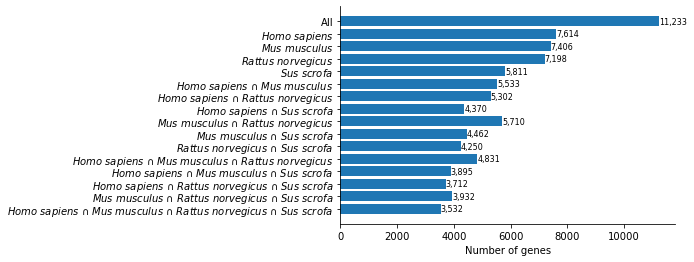

In [27]:
def staircase_plot_horiz(overlap_sets):
    '''
    This function visualizes the overlap_sets from previous cell
    '''

    # extract x and y data for bar chart
    x = []
    y = []
    for label, genes in zip(overlap_sets.keys(),overlap_sets.values()):
        if type(label) == tuple:
            label_italicized = ['$\it{%s}$ $\it{%s}$'%(l.split(" ")[0], l.split(" ")[1]) for l in label] # italicize each label
            x_ = " ∩ ".join(label_italicized)
        elif label != 'All':
            # if you don't split by spaces, it skips the space...
            label_ital = '$\it{%s}$ $\it{%s}$'%(label.split(" ")[0], label.split(" ")[1])
            x_ = label_ital # italicized
        else:
            x_ = label
        x += [x_]
        y += [len(genes)]
    # reverse values
    x = x[::-1]
    y = y[::-1]

    # labels formatted with comma
    y_labels = [f"{y_:,}" for y_ in y]
    
    # plot
    fig, ax = plt.subplots()
    plt.barh(x, y, log=False) 
    plt.xlabel('Number of genes') 
    
    # Text on the top of each bar
    for i in range(len(x)):
            plt.text(y = i-0.2 , x = y[i], s = y_labels[i], size = 8)
    
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

staircase_plot_horiz(overlap_sets)

There are two gene sets of interest: 1) the conserved mammalian cardiac proteome which is the proteins corresponding to the 3,598 genes in the intersection and 2) the human-centric consensus cardiac proteome which is based on the genes of Homo sapiens U (Mus musculus n Rattus norvegicus n Sus scrofa). We might consider also looking at genes that show up in Human, and in at least 2/3 of the model organisms so we don't lose potentially pertinent genes and aren't limited by Sus scrofa not being as well studied.

In [28]:
human_genes = set(overlap_sets['Homo sapiens'])
model_organisms = ['Mus musculus','Rattus norvegicus', 'Sus scrofa']
model_organism_genes = set()
for species in model_organisms:
    genes = set(overlap_sets[species])
    model_organism_genes = model_organism_genes.union(genes)
hccc_proteome_genes = human_genes.intersection(model_organism_genes)
print("%d genes in human"%len(human_genes))
print("%d genes in (mouse n rat n pig)"%len(model_organism_genes))
print("%d genes in human-centric consensus cardiac proteome"%len(hccc_proteome_genes))

7614 genes in human
9918 genes in (mouse n rat n pig)
6299 genes in human-centric consensus cardiac proteome


In [29]:
def ital_species(s):
    ''' italicizes species name, need to skip the space'''
    return '$\it{%s}$ $\it{%s}$'%(s.split(" ")[0], s.split(" ")[1])

def staircase_string_formatter(overlap_sets):
    ''' converts overlap_sets tuples to string to display on plot'''
    
    relabeled_overlap_sets = dict()
    for label, genes in zip(overlap_sets.keys(),overlap_sets.values()):
        if type(label) == tuple:
            label_italicized = [ital_species(s) for s in label] # italicize each label
            new_label = " ∩ ".join(label_italicized)
        elif label != 'All':
            new_label = ital_species(label) # italicized
        else:
            # don't italicize 'All'
            new_label = label
        relabeled_overlap_sets[new_label] = genes
    return relabeled_overlap_sets
    

hccc_label = " ∩ ".join([ital_species('Homo sapiens'),
                       "(%s)"%" U ".join([ital_species(s) for s in model_organisms])])
new_overlap_sets = staircase_string_formatter(overlap_sets)
new_overlap_sets[hccc_label] = hccc_proteome_genes

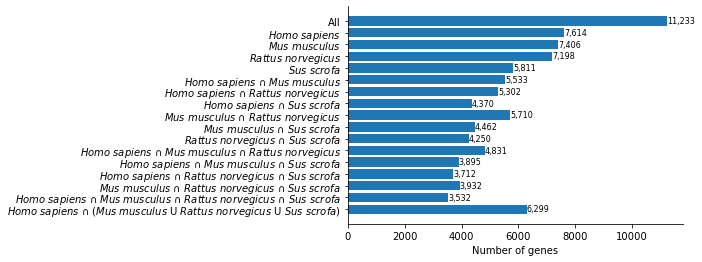

In [30]:
def staircase_plot_horiz_1(new_overlap_sets):
    '''
    This function visualizes the overlap_sets from previous cell
    '''

    # extract x and y data for bar chart
    x = []
    y = []
    for label, genes in zip(new_overlap_sets.keys(),new_overlap_sets.values()):
        x += [label]
        y += [len(genes)]

    # reverse values
    x = x[::-1]
    y = y[::-1]

    # labels formatted with comma
    y_labels = [f"{y_:,}" for y_ in y]
    
    # plot
    fig, ax = plt.subplots()
    plt.barh(x, y, log=False) 
    plt.xlabel('Number of genes') 
    
    # Text on the top of each bar
    for i in range(len(x)):
            plt.text(y = i-0.2 , x = y[i], s = y_labels[i], size = 8)
    
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    # background white
    ax.set_facecolor('white')

staircase_plot_horiz_1(new_overlap_sets)

In [31]:
# How many proteins do these intersection genes correspond to?
hccc_proteome = set()
for gene in hccc_proteome_genes:
    for species,gene_to_proteins in species_to_gene_to_proteins.items():
        if gene in gene_to_proteins:
            proteins = gene_to_proteins[gene]
            for p in proteins:
                hccc_proteome.add(p)
print("%d proteins in the human-centric consensus cardiac proteome"%(len(hccc_proteome)))

30563 proteins in the human-centric consensus cardiac proteome


In [113]:
# output
with open("human_centric_consensus_cardiac_proteome.txt","w") as out_file:
    out_file.write("\n".join(hccc_proteome))
! ls human_centric_consensus_cardiac_proteome.txt
! wc -l human_centric_consensus_cardiac_proteome.txt

human_centric_consensus_cardiac_proteome.txt
30571 human_centric_consensus_cardiac_proteome.txt


## Group into Protein Groups by Uniref 90


In [114]:
import urllib.parse
import urllib.request

def convert_string_ids_to_uniprot(query_list, out_file="./uniref_90_mapping_table.tsv"):
    '''
    This function maps STRING ID's to Uniprot accession.
    Returns a list of UniProt proteins and a mapping function
    from STRING ID's to Uniprot accession.
    '''

    # Use UniProt API to convert STRING ID's to UniProt
    url = 'https://www.uniprot.org/uploadlists/'

    params = {
    'from': 'ACC', # from UniProt
    'to': 'NF90', # to UniRef90
    'format': 'tab',
    'query': " ".join(query_list)
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
    
    # parse the results into a map
    uniprot_to_uniref = {}
    uniref_to_uniprot = {}
    raw_string = response.decode('utf-8')
    # split into table but leave out header and last line
    mapping_table = raw_string.split("\n")[1:-1]
    for l in mapping_table:
        uniprot_id,uniref_id = l.split("\t")
        # uniprot to uniref is a 1-to-1 mapping
        uniprot_to_uniref[uniprot_id] = uniref_id
        # uniref90 is a 1-to-many mapping
        if uniref_id not in uniref_to_uniprot:
            uniref_to_uniprot[uniref_id] = set()
        uniref_to_uniprot[uniref_id].add(uniprot_id)
    print("%d out of %d UniProt ID's mapped to %d UniRef90 ID's"%(len(uniprot_to_uniref.keys()),
                                                                 len(query_list),
                                                                 len(uniref_to_uniprot.keys())))
    if(out_file):
        with open(out_file,"w") as out:
            count = 1
            out.write("From\tTo")
            for uniprot, uniref in uniprot_to_uniref.items():
                out.write("\n"+"\t".join([uniprot,uniref]))
                count+=1
        print("Wrote %d lines to file %s"%(count,out_file))
    return uniprot_to_uniref, uniref_to_uniprot

uniprot_to_uniref_id, uniref_to_uniprot_ids =convert_string_ids_to_uniprot(hccc_proteome, 
                              out_file='./human_centric_consensus_cardiac_proteome_uniref90_mapping_table.tsv')

30571 out of 30572 UniProt ID's mapped to 21732 UniRef90 ID's
Wrote 30572 lines to file ./human_centric_consensus_cardiac_proteome_uniref90_mapping_table.tsv


In [115]:
! head human_centric_consensus_cardiac_proteome_uniref90_mapping_table.tsv

From	To
P53621	UniRef90_P53621
O88587	UniRef90_P22734
E7ETB4	UniRef90_E7ETB4
A0A286ZR74	UniRef90_E1BEQ5
F1RP01	UniRef90_P50904
D3ZZ37	UniRef90_D3ZZ37
Q61029	UniRef90_Q61029
C9JAV2	UniRef90_A0A0C4DFQ9
Q99P75	UniRef90_Q9R0M6


In [116]:
import pandas as pd

uniref90_df = pd.read_csv("human_centric_consensus_cardiac_proteome_uniref90_mapping_table.tsv",sep="\t")
uniref90_df

,From,To
0,P53621,UniRef90_P53621
1,O88587,UniRef90_P22734
2,E7ETB4,UniRef90_E7ETB4
3,A0A286ZR74,UniRef90_E1BEQ5
4,F1RP01,UniRef90_P50904
...,...,...
30566,Q3YEC7,UniRef90_Q3YEC7
30567,Q92556,UniRef90_Q92556
30568,C9JM14,UniRef90_P51572
30569,F7F172,UniRef90_F7F172


## Get synonyms

In [111]:
! pip install environs

     |████████████████████████████████| 47 kB 4.1 MB/s eta 0:00:011


In [116]:
! pip install xmlschema

     |████████████████████████████████| 273 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 8.2 MB/s eta 0:00:01


Previous version, it was all in lower-case synonyms. Changes for this time using protexam:
* commenting out line 119 in protexam_process.py and removing '.lower()'
* removed lower() from protexam_query.py line 534
Steps:
1. Run protexam with --get_protein_aliases
2. Run protexam with --combine_aliases_by_uniref and the new aliases

In [117]:
! python ../../protexam/protexam/protexam.py --get_protein_aliases ./human_centric_consensus_cardiac_proteome.txt

** ProtExAM **
Retrieving UniProtKB entries for 30572 accessions.
XML output will be in multiple files.
100%|█████████████| 30572/30572 [14:53<00:00, 34.23 protein entries retrieved/s]
Parsing XML entries...
Parsing ../queries/ProteinQuery_2022-05-18_23_10_19/prot_entries_0.xml (1 out of 31 files).
Parsing ../queries/ProteinQuery_2022-05-18_23_10_19/prot_entries_1.xml (2 out of 31 files).
Parsing ../queries/ProteinQuery_2022-05-18_23_10_19/prot_entries_2.xml (3 out of 31 files).
Parsing ../queries/ProteinQuery_2022-05-18_23_10_19/prot_entries_3.xml (4 out of 31 files).
Parsing ../queries/ProteinQuery_2022-05-18_23_10_19/prot_entries_4.xml (5 out of 31 files).
Parsing ../queries/ProteinQuery_2022-05-18_23_10_19/prot_entries_5.xml (6 out of 31 files).
Parsing ../queries/ProteinQuery_2022-05-18_23_10_19/prot_entries_6.xml (7 out of 31 files).
Parsing ../queries/ProteinQuery_2022-05-18_23_10_19/prot_entries_7.xml (8 out of 31 files).
Parsing ../queries/ProteinQuery_2022-05-18_23_10_19/prot

In [122]:
! cp ../queries/ProteinQuery_2022-05-18_23_10_19/aliases.txt .
! head ./aliases.txt

P53621|Q5T201|Q8IXZ9|COPA_HUMAN|Coatomer_subunit_alpha|Alpha-coat_protein|HEP-COP|COPA
O88587|Q91XH4|COMT_MOUSE|Catechol_O-methyltransferase|Comt|Comt1
E7ETB4|E7ETB4_HUMAN|Clusterin|CLU
A0A286ZR74|A0A286ZR74_PIG|Angiomotin_like_1|AMOTL1
F1RP01|F1RP01_PIG|RAS_p21_protein_activator_1|RASA1
D3ZZ37|D3ZZ37_RAT|Mitochondrial_assembly_of_ribosomal_large_subunit_1|Malsu1|RGD1306936_predicted|rCG_52366
Q61029|Q3UCI5|Q61030|Q61031|Q61032|LAP2B_MOUSE|Lamina-associated_polypeptide_2,_isoforms_beta/delta/epsilon/gamma|Thymopoietin_isoforms_beta/delta/epsilon/gamma|Tmpo|Lap2
C9JAV2|C9JAV2_HUMAN|DCN1-like_protein|Defective_in_cullin_neddylation_protein_1-like_protein|DCUN1D2
Q99P75|Q6NS34|RAB9A_RAT|Ras-related_protein_Rab-9A|Rab9a|Rab9
C9JY20|C9JY20_HUMAN|Fragile_X_mental_retardation_syndrome-related_protein_1|FXR1


In [123]:
! python ../../protexam/protexam/protexam.py --combine_aliases_by_uniref ./aliases.txt ./human_centric_consensus_cardiac_proteome_uniref90_mapping_table.tsv

** ProtExAM **
Combining aliases in ./aliases.txt based on UniRef groups in ./human_centric_consensus_cardiac_proteome_uniref90_mapping_table.tsv
Parsed 30572 UniProt IDs with 178451 aliases.
Parsed 21732 UniRef IDs with 30571 protein IDs.
Wrote output to /home/ubuntu/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/cardiac_proteome_curation/combined_aliases.txt
Exiting...


In [124]:
! ls combined_aliases.txt
! head -n 20 combined_aliases.txt

combined_aliases.txt
UniRef90_P53621|F1RJX8_PIG|Coatomer_subunit_alpha|COPA
UniRef90_P22734|COMT_RAT|Catechol_O-methyltransferase|Comt
UniRef90_E7ETB4|E7ETB4_HUMAN|Clusterin|CLU
UniRef90_E1BEQ5|A0A286ZTR1_PIG|Angiomotin_like_1|AMOTL1
UniRef90_P50904|G3V9H0_RAT|Ras_GTPase-activating_protein_1|Rasa1
UniRef90_D3ZZ37|D3ZZ37_RAT|Mitochondrial_assembly_of_ribosomal_large_subunit_1|Malsu1|RGD1306936_predicted|rCG_52366
UniRef90_Q61029|Q3UCI5|Q61030|Q61031|Q61032|LAP2B_MOUSE|Lamina-associated_polypeptide_2,_isoforms_beta/delta/epsilon/gamma|Thymopoietin_isoforms_beta/delta/epsilon/gamma|Tmpo|Lap2
UniRef90_A0A0C4DFQ9|C9JAV2_HUMAN|DCN1-like_protein|Defective_in_cullin_neddylation_protein_1-like_protein|DCUN1D2
UniRef90_Q9R0M6|K7GKQ1|K7GPC9|F1SRI1_PIG|RAB9A,_member_RAS_oncogene_family|RAB9A
UniRef90_P51114|C9J5B4_HUMAN|Fragile_X_mental_retardation_syndrome-related_protein_1|FXR1
UniRef90_Q920A5|Q9D625|RISC_MOUSE|Retinoid-inducible_serine_carboxypeptidase|Serine_carboxypeptidase_1|Scpep1|Risc
UniR

In [138]:
! cp ./combined_aliases.txt ../caseolap/input/entities.txt

### Generate figures

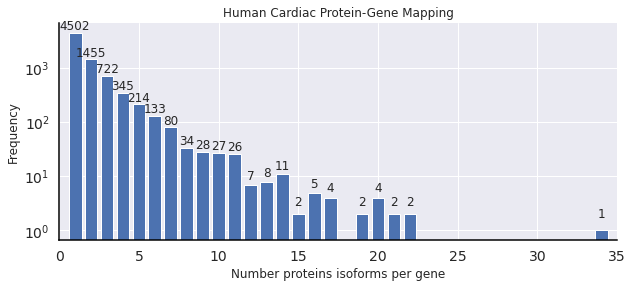

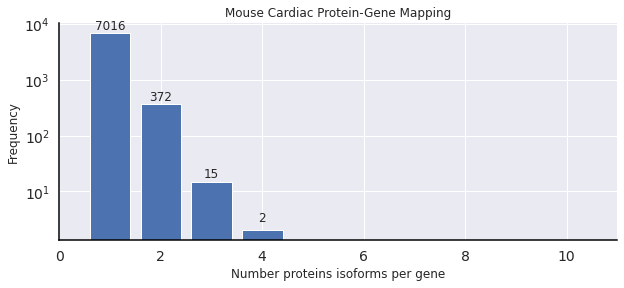

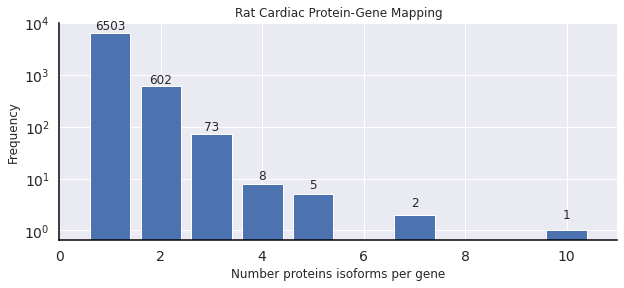

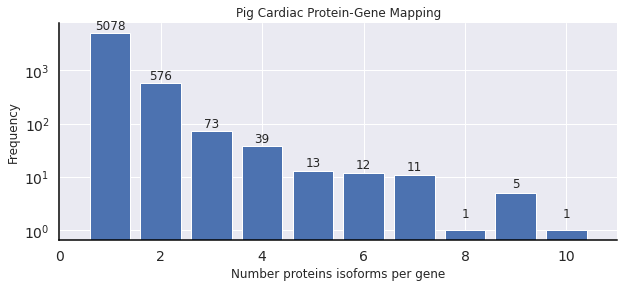

In [34]:
import collections
import matplotlib.pyplot as plt
import numpy as np

def gene_histogram(gene_to_protein_set, tag="", out_file = "./figures/gene_histogram.pdf"):
    '''
    This function takes a gene to protein set mapping and makes a histogram
    showing the number of proteins that correspond to each gene. 
    '''
    
    # Make plot area and background to see on notebook better
    fig, ax = plt.subplots(figsize = [10,4])
    fig.patch.set_facecolor('white')

    # collect frequencies
    freqs = []
    for gene in gene_to_protein_set:
        freqs += [len(gene_to_protein_set[gene])]
    x = np.array(range(max(freqs)))+1
    
    # gather histogram data and plot
    coll = collections.Counter(freqs)
    y = [coll[x_] for x_ in x]
    plt.bar(x, y, log=True)

    # Text on the top of each bar
    for i in range(len(x)):
        if y[i] > 0:
            plt.text(x = x[i] , y = y[i]+0.5, s = str(y[i]), size = 12, va='bottom', ha = 'center')
            
    # formatting 
    plt.xlabel('Number proteins isoforms per gene') 
    plt.ylabel('Frequency') 
    plt.title("%s Cardiac Protein-Gene Mapping"%tag)
    ax.tick_params(axis='both', labelsize=14)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # set x-axis
    if max(x) <= 10:
        plt.xlim([0,10+1])
    else:
        plt.xlim([0,max(x)+1])
    
    # # save file if file name is given
    if len(out_file) > 0:
            fig.savefig(out_file,bbox_inches="tight")
    plt.show()

    
colloquial_species_name = {'Homo sapiens':'Human',
                          'Mus musculus':'Mouse',
                          'Rattus norvegicus':'Rat',
                          'Sus scrofa':'Pig'}
for species, gene_to_protein_set in species_to_gene_to_proteins.items():
    out_file_name = "./figures/%s_gene_histogram.pdf"%(colloquial_species_name[species])
    gene_histogram(gene_to_protein_set, tag = colloquial_species_name[species],out_file=out_file_name)

## Two visualization plots
1. Histogram showing how many datasets each protein shows up and its frequency
2. Heatmap showing the number of overlapping proteins between pairs of datasets

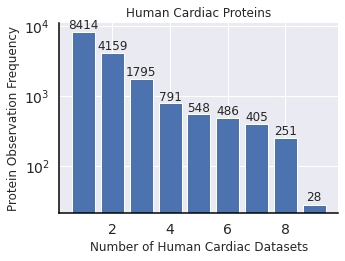

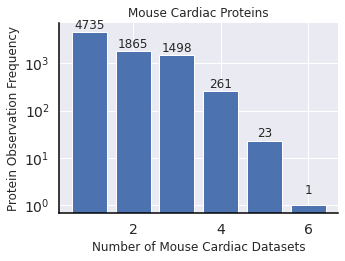

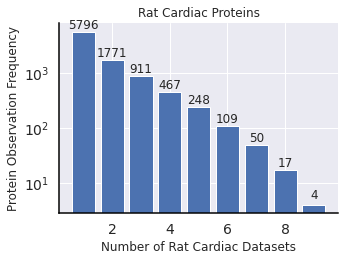

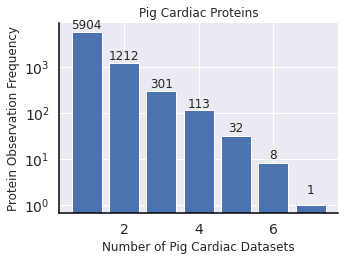

In [53]:
import collections
import matplotlib.pyplot as plt
import numpy as np

def histogram(unique_proteins, id_to_proteins, tag="", out_file = "./figures/dataset_histogram.pdf"):
    '''
    This function reads all the .txt files in the input directory and finds out 
    how many of these files are each of the proteins found in. Then plots it. 
    '''
    
    # Make plot area and background to see on notebook better
    fig, ax = plt.subplots(figsize = [5,3.5])
    fig.patch.set_facecolor('white')

    # frequency for each protein
    protein_to_datasets = {}
    freqs = []
    for p in unique_proteins:
        datasets = set()
        for dset in id_to_proteins.keys():
            if p in id_to_proteins[dset]:
                datasets.add(dset)
        freqs += [len(datasets)]
    
    x = np.array(range(max(freqs)))+1
    coll = collections.Counter(freqs)
    y = [coll[x_] for x_ in x]
    plt.bar(x, y, log=True)

   # Text on the top of each bar
    for i in range(len(x)):
        if y[i] > 0:
            plt.text(x = x[i] , y = y[i]+0.5, s = str(y[i]), size = 12, va='bottom', ha = 'center')
            
    # formatting 
    plt.xlabel('Number of %s Cardiac Datasets'%(tag)) 
    plt.ylabel('Protein Observation Frequency') 
    plt.title("%s Cardiac Proteins"%tag)
    ax.tick_params(axis='both', labelsize=14)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # set x-axis
#     plt.xlim([0,12.5])
    
    # # save file if file name is given
    if len(out_file) > 0:
            fig.savefig(out_file,bbox_inches="tight")
    plt.show()
    
    
species_to_id_to_proteins = {'Homo sapiens':human_id_to_proteins,
                          'Mus musculus':mouse_id_to_proteins,
                          'Rattus norvegicus':rat_id_to_proteins,
                          'Sus scrofa':pig_id_to_proteins}
for species, id_to_proteins in species_to_id_to_proteins.items():
    out_file_name = "./figures/%s_dataset_histogram.pdf"%(colloquial_species_name[species])
    histogram(unique_proteins, id_to_proteins, tag = colloquial_species_name[species],out_file=out_file_name)
    

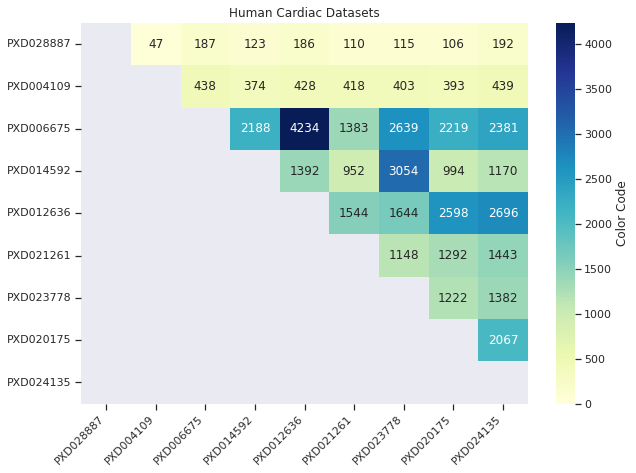

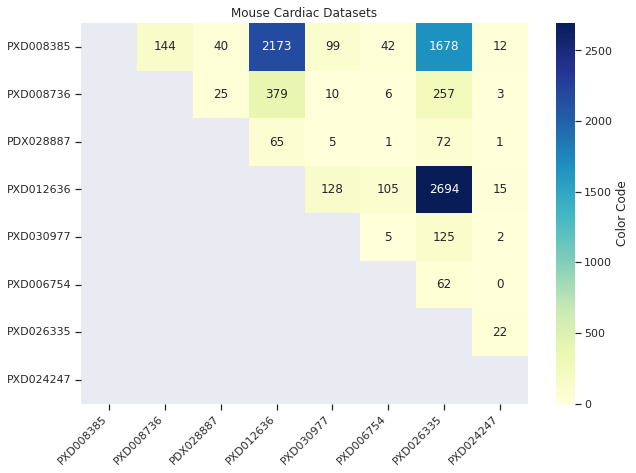

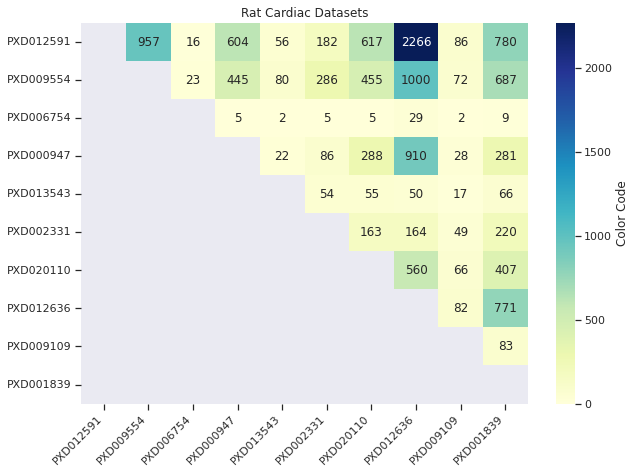

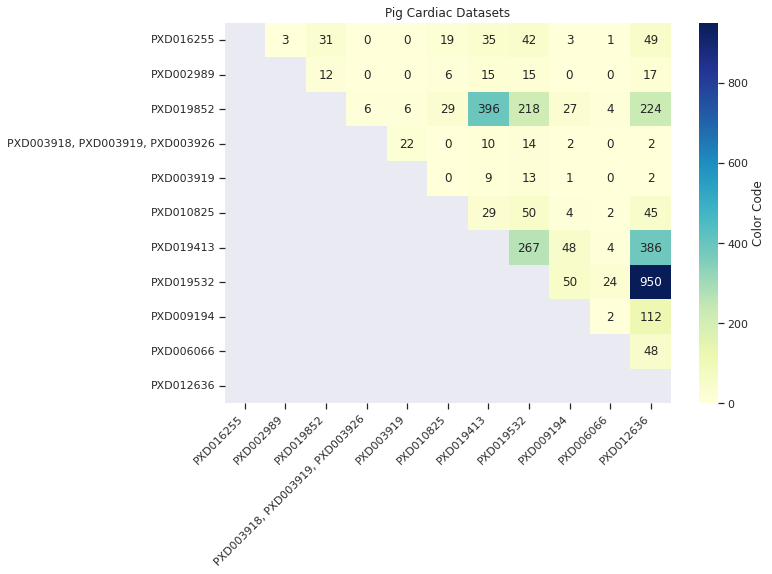

In [52]:
import numpy as np
import seaborn as sns; sns.set_theme()
import pandas as pd

def heatmap(id_to_proteins, tag="", out_file = "./figures/dataset_histogram.pdf"):
    '''
    This function reads all the .txt files in the input directory and merges the unique identifiers into merged_list.txt
    '''

    fig = plt.gcf()
    fig.set_size_inches(10, 7)
    
    # get overlap matrix
    #print(id_to_proteins)
    df = pd.DataFrame(columns=id_to_proteins.keys())
    for id1 in id_to_proteins.keys():
        
        row = {}
        for id2 in id_to_proteins.keys():
            p1 = id_to_proteins[id1]
            p2 = id_to_proteins[id2]
            overlap = p1.intersection(p2)
            row[id2] = len(overlap)
        df = df.append(row,ignore_index=True)
    #print(df)

    # replace rows and column labels
    new_headers = list(id_to_proteins.keys())
    # rename one label
    if 'mayer_pubs' in new_headers:
        new_headers[new_headers.index("mayer_pubs")] = "PXD003918, PXD003919, PXD003926"
    new_headers = [h.split("_")[0] for h in new_headers]
    # new_headers[new_headers.index("mayer_pubs")] = "Mayr Lab"
    df.columns = new_headers
    df.index = new_headers
    df = df.astype('int32')
    
    # grey out the lower right quadrant
    mask = []
    for i in range(len(id_to_proteins)):
        m = []
        for j in range(len(id_to_proteins)):
            m += [(j <= i)]
        mask += [m]
    mask = pd.DataFrame(mask)
    mask.columns=new_headers
    mask.index=new_headers

    ax = sns.heatmap(df, annot=True, fmt="d", mask=mask, 
                                     vmin=0, cmap='YlGnBu',
                                    cbar_kws={'label':'Color Code'})
    
    # set title text
    ax.set_title("%s Cardiac Datasets"%(tag))
    
    # rotate x axis labels
    ax.set_xticklabels(
        ax.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right'
    )
    
    # set tick marks
    ax.tick_params(left=True,bottom=True)
        
    # # save file if file name is given
    if len(out_file) > 0:
            fig.savefig(out_file,bbox_inches="tight")
    plt.show()
    

for species, id_to_proteins in species_to_id_to_proteins.items():
    out_file_name = "./figures/%s_dataset_heatmap.pdf"%(colloquial_species_name[species])
    heatmap(id_to_proteins, tag = colloquial_species_name[species],out_file=out_file_name)
